In [1]:
#To run locally without ipython: 
#/Users/kayote/anaconda/bin/python2.7 test.py

In [2]:
from __future__ import print_function

# We'll need numpy for some mathematical operations
import numpy as np
import copy

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
import librosa.display
import pandas as pd
import tensorflow as tf
import timeit
import pickle 

from joblib import Parallel, delayed
import multiprocessing
import os
import time

num_cores = multiprocessing.cpu_count()
print(num_cores)
    


/Users/kayote/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


8


In [3]:
load_training_data = False
append_training_data = False
train_model = False
#also what's the deal with keep_prob4? it's not actually used
#basically these global options are so I can set up the deep model to restore and test on new stuff
#for the mobile app and future stuff we will need to extract the model restore part on its own somehow

# Define HyperParameters

In [4]:
data_hyper_parameters = {
    #'data_date': time.strftime("%Y%m%d"),
    'perc_multiplier_max':1.0, #ratio of percussion noise energy to note energy
    'data_multiplier':8,  #on my laptop num_cores is 8 so this does two cycles
    'make_singles':True,
    'make_doubles':True,
    'make_zeros':True,
    'make_extensions':True,
    'make_sevenths':True,
    'pitch_range':(40,63),
    'pitch_shift_range':(-0.1,0.1), #(-0.1,0.1), in semitones
    'inter_note_pitch_shift_range':(-0.1,0.1), #(-0.1,0.1), in semitones
    'note_weight_range':(0.25,1.0), # if first is close to 0, we get classification ambiguity
    'make_pitches_per_pitch_class':'all',
    'make_note_bank':'all'    #bass trombone, grand piano, ..., mixture, all
}

model_only_hyper_parameters = {
    #'model_date': time.strftime("%Y%m%d"),
    'net_size_multiplier':64,
    'seed':27,
    'batch_size':3000,
    'adam_size':5e-5, #5e-5
    'regularizer_size':1e-5,#1e-4
    'use_note_bank':'all',    #bass trombone, grand piano, ..., mixture, all
    'use_extensions':True,
    'use_sevenths':True,
    'use_zeros':True,
    'use_singles':True,
    'use_doubles':True,
    'input_column':'fft',
    'output_column':'binary_triad', #'binary triad' and 'binary quadrad' and 'binary encoding'
    'train_ratio':0.8,
    'validation_ratio':0.1
}

output_hyper_parameters = {
    'step_update_in_seconds':30,
    'loss_diff_thresh':0.01,        #above 1 means never, in terms of fractional improvement (see code)
    'num_train_steps_thresh':1e5,   #total number of allowed training steps to run
    'element_accuracy_thresh':1.5,  #above 1 means never
    'row_accuracy_thresh':0.999    #above 1 means never
    
}

#data_hyper_parameters.update({'samples_hyper_parameters':samples_hyper_parameters}) #does this run?

model_hyper_parameters = data_hyper_parameters.copy()
model_hyper_parameters.update(model_only_hyper_parameters)

hyper_parameters = model_hyper_parameters.copy()
hyper_parameters.update(output_hyper_parameters)

data_hash = abs(hash(frozenset(data_hyper_parameters.iteritems())))
model_hash = abs(hash(frozenset(model_hyper_parameters.iteritems())))
all_hash = abs(hash(frozenset(hyper_parameters.iteritems())))

model_file_name = str(abs(data_hash))+"_"+str(abs(model_hash))+'_Model.ckpt'
model_output_file_name = str(abs(data_hash))+"_"+str(abs(model_hash))+"_"+str(abs(all_hash))+'_ModelOutput.p'
data_prep_file_name = str(abs(data_hash))+'_DataPrep.p'
hyper_parameters_file_name = str(abs(data_hash))+"_"+str(abs(model_hash))+"_"+str(abs(all_hash))+'_HyperParameters.p'

hyper_parameters.update({
        'model_file_name': model_file_name,
        'data_prep_file_name': data_prep_file_name,
        'hyper_parameters_file_name': hyper_parameters_file_name,
        'model_output_file_name': model_output_file_name,
    })


if not os.path.isfile(hyper_parameters['hyper_parameters_file_name']):
    pickle.dump((data_hyper_parameters,model_only_hyper_parameters,output_hyper_parameters,hyper_parameters),open(hyper_parameters['hyper_parameters_file_name'],'w'))
    print("Saved Hyper Parameters to %s"%hyper_parameters['hyper_parameters_file_name'])
    print(' ')
else:  
    print("Hey, you've saved this already!")
    



Hey, you've saved this already!


In [5]:
data_hyper_parameters,model_only_hyper_parameters,output_hyper_parameters,hyper_parameters = pickle.load( open( hyper_parameters_file_name, "rb" ) )
print("Loaded Hyper Parameters")

Loaded Hyper Parameters


# Load/Create/Update {data_hash}_DataPrep.p

In [6]:
if load_training_data:

    #Load the newest samples file
    dated_files = [(os.path.getmtime(fn), os.path.basename(fn)) 
                   for fn in os.listdir('.') if fn.endswith('_SamplesWithPitchShiftFFT.p')]
    dated_files.sort()
    dated_files.reverse()
    newest = dated_files[0][1]
    print("Loading Samples with Pitch Shift FFT from %s"%newest)
    samples = pickle.load( open( newest, "rb" ) )
    print("Samples Loaded Here's The Size:")
    print(samples.shape)
    print("Here are the sample banks")
    present_banks = np.unique(samples['bank'])
    print(present_banks)
    print(" ")
    print("Here is a peek")
    print(samples.head())
    print(" ")

    samples['pitch_shift_in_cents'] = [round(100.0*x) for x in samples['pitch_shift']]



In [7]:
#returns one pitch (and octave) from all_notes for each pitch_class represented in all_notes
def get_played_notes(all_notes):
    pitch_classes = [x%12 for x in all_notes]
    octave = [int(np.floor((x-x%12)/12.0)) for x in all_notes]
    available_octaves_per_pitch_class = {}
    available_pitches_per_pitch_class = {}
    for pitch_class in np.unique(pitch_classes):
        ind = np.where(pitch_classes==pitch_class)[0]
        available_octaves_per_pitch_class.update(
            {pitch_class:[octave[x] for x in ind]
            })
        available_pitches_per_pitch_class.update(
            {pitch_class:[all_notes[x] for x in ind]
            })
        
    return_pitches = {}
    for pitch_class in np.unique(pitch_classes):
        ind = np.where(pitch_classes==pitch_class)[0]
        available_pitches = [all_notes[x] for x in ind]
        tmp_ind = np.random.choice(list(available_pitches))
        return_pitches.update({
                pitch_class:tmp_ind
            })
    
    return [x[1] for x in return_pitches.items()]

#test
#for i in range(15):
#    a = get_played_notes([0,5,10,12,15,17,16])
#    print(a)

In [8]:
def get_chord_pitches(root,majmin3='maj',majmin7='none',extensions=[]):
    
    fundamental = root%12
    fundamentals = [fundamental + x*12 for x in range(12)]
    
    all_of_them = fundamentals
    if majmin3 =='maj': all_of_them += [(fundamental+4)%12 + x*12 for x in range(12)]
    if majmin3 =='min': all_of_them += [(fundamental+3)%12 + x*12 for x in range(12)]
    all_of_them += [(fundamental+7)%12 + x*12 for x in range(12)]
    if majmin7 =='maj': all_of_them += [(fundamental+11)%12 + x*12 for x in range(12)]
    if majmin7 =='min': all_of_them += [(fundamental+10)%12 + x*12 for x in range(12)]
    for extension in extensions:
        if extension not in range(12): continue
        all_of_them += [(fundamental+extension)%12 + x*12 for x in range(12)]
        
    return sorted([num for num in all_of_them if num >= 1 and num <= 127])

          
                      
#Pass in velocity and bank-restricted samples and perc samples
def make_chord_with_perc(samples,perc_samples,note_weight_range=(0.25,1.0),inter_note_pitch_shift_range=(0.0,0.0),n_steps=0.0,perc_multiplier=0.0):

    pitch_shift = round(100.0*n_steps)/100.0
    pitch_dict = []
    
    if samples.shape[0]>0: 
        
        good_weights = []
        ever_worked = False

        note_index = np.where((samples['pitch_shift']==0.0))[0]
        #note_index_with_all_pitch_shift = np.where((samples['pitch']==all_notes[i]))[0]

        if len(note_index)==0:
            print('Sample FFT does not exist')
            return ([],[])

        for j in note_index:

            inter_note_pitch_shift = round(np.random.uniform(inter_note_pitch_shift_range[0],inter_note_pitch_shift_range[1],1)*100.0)/100.0
            total_pitch_shift = round(100.0*(pitch_shift+inter_note_pitch_shift)/100.0)
            if total_pitch_shift >= 0.5: total_pitch_shift = 0.49
            if total_pitch_shift <= -0.5: total_pitch_shift = -0.49

            pitch = samples['pitch'].iloc[j]
            vel = samples['vel'].iloc[j]
            bank = samples['bank'].iloc[j]
            single_index = np.where((samples['bank']==bank) & (samples['pitch']==pitch) & (samples['vel']==vel) & (samples['pitch_shift_in_cents']==round(100.0*total_pitch_shift)))
            if len(single_index)!=1: print("Error: incorrect # of matching indices: %g indices for vel %g and bank %s and pitch_shift %g"%(len(single_index),vel,bank,total_pitch_shift))

            weight = float(np.random.uniform(note_weight_range[0],note_weight_range[1],1))
            pitch_dict.append({'pitch':pitch,'vel':vel,'bank':bank,'pitch_shift':total_pitch_shift,'weight':weight})
            
            tmp = np.array(samples['fft'].iloc[single_index])[0]
            if not ever_worked: 
                tmp2 = tmp
                ever_worked = True
                good_weights = [weight]
            else: 
                tmp2 = np.vstack((tmp2,tmp))
                good_weights += [weight]
                    
        if not ever_worked:
            print("No notes matching pitch class!")
            return ([],[])

        if len(good_weights)==1:
            fft = tmp2
        else:    
            good_weights = np.multiply(1.0/float(np.sum(good_weights)),good_weights) #normalize so sum is 10
            fft = np.dot(good_weights.transpose(),tmp2)
    else:
        fft = np.zeros(perc_samples['fft'].iloc[0].shape[0])
    
    #weights for percussion
    if perc_multiplier>0.0:
        
        ever_worked = False
        
        note_index = np.where((perc_samples['pitch_shift']==0.0))[0]
        #note_index_with_all_pitch_shift = np.where((samples['pitch']==all_notes[i]))[0]

        if len(note_index)==0:
            print('Sample FFT does not exist')
            return ([],[])

        for j in note_index:

            total_pitch_shift = round(np.random.uniform(-0.49,0.49,1)*100.0)/100.0
            if total_pitch_shift >= 0.5: total_pitch_shift = 0.49
            if total_pitch_shift <= -0.5: total_pitch_shift = -0.49

            vel = perc_samples['vel'].iloc[j]
            bank = perc_samples['bank'].iloc[j]
            pitch = perc_samples['pitch'].iloc[j]
            single_index = np.where((perc_samples['bank']==bank) & (perc_samples['vel']==vel) & (perc_samples['pitch']==pitch) & (perc_samples['pitch_shift_in_cents']==round(100.0*total_pitch_shift)))
            if len(single_index)!=1: print("Error: incorrect # of matching indices: %g indices for vel %g and bank %s and pitch_shift %g"%(len(single_index),vel,bank,total_pitch_shift))


            weight = float(np.random.uniform(0.0,1.0,1))
            pitch_dict.append({'pitch':pitch,'vel':vel,'bank':bank,'pitch_shift':total_pitch_shift,'weight':weight})    
            
            tmp = np.array(perc_samples['fft'].iloc[single_index])[0]
            if not ever_worked: 
                tmp2 = tmp
                ever_worked = True
                good_weights = [weight]
            else: 
                tmp2 = np.vstack((tmp2,tmp))
                good_weights += [weight]
                
        if not ever_worked: print("Didn't add percussion")
        good_weights = np.multiply(1.0/float(np.sum(good_weights)),good_weights) #normalize so sum is 1.0
        good_weights = np.multiply(perc_multiplier,good_weights) #multiplier
        fft += np.dot(good_weights.transpose(),tmp2)
    
    return fft/np.sum(fft), pitch_dict#, sample[0]/np.max(sample[0])


    
def to1hot(row,num_categories=2):
    one_hot = np.zeros(num_categories)
    one_hot[row]=1.0
    return one_hot

def toMultiHot(pitch_bank,num_categories=12):
    output = np.zeros(num_categories)
    for i in pitch_bank:
        output[i] = 1
    return output

In [9]:
#samples['pitch'][(samples['bank']=='string ensemble') & (samples['vel']==128)]
#samples['pitch'][(samples['bank']=='percussion') & (samples['vel']==128)]
#samples[samples['bank']=='grand piano']

In [10]:
if load_training_data:

    #Load the newest dataprep file with same hyper parameters
    dated_files = [(os.path.getmtime(fn), os.path.basename(fn)) 
                   for fn in os.listdir('.') if fn == hyper_parameters['data_prep_file_name']]
    dated_files.sort()
    dated_files.reverse()
    if len(dated_files)==0:
        ds = pd.DataFrame()
        data_prep_times = pd.DataFrame()
        print("creating new DataPrep file from scratch")
    else:
        newest = dated_files[0][1]
        print("Loading DataPrep from %s"%newest)
        ds,data_prep_times,data_prep_hyper_parameters = pickle.load( open( newest, "rb" ) )
        print("DataPrep Loaded Here's The Size:")
        print(ds.shape)
        print(" ")


    all_sample_banks = sorted(np.unique(samples['bank']))
    print("All sample banks")
    print(all_sample_banks)


In [11]:

label_to_chord = []
n = -1
set_created = False

if hyper_parameters['make_extensions']:
    extensions = ('none', 1, 2, 3, 4, 5, 6, 8, 9, 10, 11) #skip 7
else:
    extensions = ('none',)
    
    
if hyper_parameters['make_sevenths']:
    majmin7 = ('none', 'maj', 'min')
else:
    majmin7 = ('none',)
    
for l in extensions:
    for k in majmin7:
        for j in ('maj','min'):
            for i in range(12):
                if j=='maj' and l==4: continue
                if j=='maj' and l==3: continue #so we don't majmin3==maj+3 as well as majmin3==min+14
                if j=='min' and l==3: continue #leaves only majmin3==min+4
                if k=='none' and l==11: continue
                if k=='none' and l==10: continue
                if k=='maj' and l==11: continue
                if k=='maj' and l==10: continue #so we don't majmin7==maj+10 as well as majmin7==min+11
                if k=='min' and l==10: continue #leaves only majmin7==min+11
                all_notes = set([0,7])
                if j=='maj': all_notes.add(4)
                if j=='min': all_notes.add(3)
                if k=='maj': all_notes.add(11)
                if k=='min': all_notes.add(10)
                if l!='none': all_notes.add(l)
                all_notes = frozenset([(x+i)%12 for x in all_notes])
                if set_created and all_notes in set_of_all_chords: 
                    #print(all_notes)
                    continue
                if not set_created: 
                    set_of_all_chords = {all_notes}
                    set_created = True
                else: 
                    set_of_all_chords.add(all_notes)
                #k = 'none'
                n += 1
                label_to_chord.append({'root':i, 'majmin3': j, 'majmin7': k, 'extensions': l, 'pitch_class': sorted(list(all_notes))}) 
                #it's annoying that list and ds behavior is different here
        



In [12]:
def tmp2(j): #implicit tmp_note_bank and pitches_per_pitch_class
    np.random.seed(j)
    n_steps = round(100*float(np.random.uniform(hyper_parameters['pitch_shift_range'][0],hyper_parameters['pitch_shift_range'][1],1)))/100.0
    perc_multiplier = float(np.random.uniform(0.0,hyper_parameters['perc_multiplier_max'],1))

    all_notes = [x + 12*y for x in pitch_class for y in range(12)]
    all_notes = sorted([num for num in all_notes if num >= hyper_parameters['pitch_range'][0] and num <= hyper_parameters['pitch_range'][1]])
    
    if str(pitches_per_pitch_class) == '1':
        all_notes = get_played_notes(all_notes)
        
    available_notes = np.unique(passed_samples['pitch'][passed_samples['pitch_shift']==0.0])
    if len(np.setdiff1d(all_notes,available_notes))>0: 
        print('This Bank Doesnt Have All The Notes!')
        return []
    
    pitch_index = np.where([x in all_notes for x in passed_samples['pitch']])[0]
    
    #TO DO: implement one-of-any (each pitch is assigned a randomized bank)
    bank_for_note = {}
    if tmp_note_bank=='one bank of any per pitch':
        pitch_index = []
        for pitch in all_notes:
            bank = str(np.random.choice(np.setdiff1d(all_sample_banks,'percussion'),1)[0])
            bank_for_note[pitch] = bank            
            pitch_index += list(np.where([passed_samples['pitch'].iloc[i]==pitch and passed_samples['bank'].iloc[i]==bank for i in range(passed_samples.shape[0])])[0])   
        #print(str(bank_for_note)+str(pitch_index))
                                     
    #print(len(pitch_index))
    chord_fft, pitch_dict = make_chord_with_perc(passed_samples.iloc[pitch_index],passed_perc_samples,inter_note_pitch_shift_range=hyper_parameters['inter_note_pitch_shift_range'],n_steps=n_steps,perc_multiplier=perc_multiplier)
    
    if len(chord_fft)==0: 
        print("Chord FFT Failure")
        return None
    tmp_dict = {'fft':chord_fft,
                'pitch_shift':n_steps,
                'pitch_shift_range':hyper_parameters['pitch_shift_range'],
                'pitch_class':pitch_class,
                'pitches': all_notes,
                'repetition':j,
                'bank':tmp_note_bank,
                'vel':vel,
                'perc_multiplier_max':hyper_parameters['perc_multiplier_max'],
                'perc_multiplier':perc_multiplier,
                'pitches_per_pitch_class':pitches_per_pitch_class,
                'inter_note_pitch_shift_range':hyper_parameters['inter_note_pitch_shift_range'],
                'data_hyper_parameters':data_hyper_parameters,
                'bank_for_note':bank_for_note,
                'pitch_dict':pitch_dict}
    if opt_add_chord:
        tmp_dict.update({'target':label_to_chord_index})
        tmp_dict.update(label_to_chord[label_to_chord_index])
    else:
        tmp_dict.update({'root':'none','majmin3':'none','majmin7':'none','extensions':'none'})
    return tmp_dict

In [13]:
if load_training_data and append_training_data:

    data_prep_start = timeit.default_timer()
    data_multiplier=hyper_parameters['data_multiplier']
    num_reps = data_multiplier
    vel = 128
    perc_index = np.where((samples['bank']=='percussion') & (samples['vel']==vel))[0]
    passed_perc_samples = samples.iloc[perc_index]

    #parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp2)(i) for i in range(num_reps))
    #print(parallel_output[0])

    if hyper_parameters['make_note_bank'] == 'all':
        if len(all_sample_banks)==0:
            all_note_banks = tuple()
        else:
            all_note_banks = copy.copy(all_sample_banks)
            all_note_banks = np.setdiff1d(all_note_banks,'percussion')
            all_note_banks = list(all_note_banks)
            all_note_banks += ['mixture']
            all_note_banks += ['one bank of any per pitch']
            all_note_banks = tuple(all_note_banks)
    else:
        all_note_banks = np.setdiff1d(hyper_parameters['make_note_bank'],np.setdiff1d(all_sample_banks,'percussion'))
        all_note_banks = tuple(all_note_banks)

    if hyper_parameters['make_pitches_per_pitch_class'] == 'all':
        all_pitches_per_pitch_class = ('1','any')
    else:
        all_pitches_per_pitch_class = (hyper_parameters['make_pitches_per_pitch_class'],)


    for pitches_per_pitch_class in ('1','any',):#all_pitches_per_pitch_class:
        for tmp_note_bank in all_note_banks:

            #for botched runs
            normal_len = np.sum((ds['pitches_per_pitch_class']=='1') & (ds['bank']==all_note_banks[0]))
            curr_len = np.sum((ds['pitches_per_pitch_class']==str(pitches_per_pitch_class)) & (ds['bank']==tmp_note_bank))
            #print("Normal %g Current %g"%(normal_len,curr_len))
            if ds.shape[0]>0 and curr_len==normal_len: 
                print('skipping pitches per pitch class '+str(pitches_per_pitch_class)+' and note bank '+str(tmp_note_bank)+" since it's already been computed")
                continue
            elif ds.shape[0]>0 and curr_len>0 and curr_len!=normal_len: 
                print('deleting partially-run pitches per pitch class '+str(pitches_per_pitch_class)+' and note bank '+str(tmp_note_bank)+" since it's already been computer")
                index = np.where((ds['pitches_per_pitch_class']==str(pitches_per_pitch_class)) & (ds['bank']==tmp_note_bank))[0]
                print(len(index))
                ds = ds.iloc[np.setdiff1d(range(ds.shape[0]),index)]
                print(ds.shape)
                print(ds_tmp.shape)
                curr_len = np.sum((ds['pitches_per_pitch_class']==str(pitches_per_pitch_class)) & (ds['bank']==tmp_note_bank))
            elif ds.shape[0] and curr_len==0:         
                print('Computing pitches per pitch class '+str(pitches_per_pitch_class)+' and note bank '+str(tmp_note_bank)+" since it hasnt been done yet!")
            else: print("what?")


            #ween down passed_samples based on bank and velocity
            if tmp_note_bank=='mixture' or tmp_note_bank=='one bank of any per pitch': 
                index_for_bank_and_vel = np.where((samples['bank'] != 'percussion') & (samples['vel']==vel) & (samples['pitch_shift']>=(hyper_parameters['pitch_shift_range'][0]+hyper_parameters['inter_note_pitch_shift_range'][0])) & (samples['pitch_shift']<=(hyper_parameters['pitch_shift_range'][1]+hyper_parameters['inter_note_pitch_shift_range'][1])))[0]
            else:
                index_for_bank_and_vel = np.where((samples['bank'] == tmp_note_bank) & (samples['vel']==vel) & (samples['pitch_shift']>=(hyper_parameters['pitch_shift_range'][0]+hyper_parameters['inter_note_pitch_shift_range'][0])) & (samples['pitch_shift']<=(hyper_parameters['pitch_shift_range'][1]+hyper_parameters['inter_note_pitch_shift_range'][1])))[0]
            passed_samples = samples.iloc[index_for_bank_and_vel]


            start = timeit.default_timer()

            opt_add_chord = False
            print('Bank: '+str(tmp_note_bank) + "; Pitches per Pitch Class: " + str(pitches_per_pitch_class))

            #zero notes
            if hyper_parameters['make_zeros']:
                print('Doing zero-notes')
                pitch_class = []
                parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp2)(i) for i in range(num_reps))
                ds = ds.append([x for x in parallel_output if x != None],ignore_index=True)

            #one notes
            if hyper_parameters['make_singles']:
                print('Doing one-notes')
                for i1 in range(12):
                    print("Step %g of %g at %g percent: "%(i1,12,100*(i1)/(12.)))
                    pitch_class = [i1]
                    parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp2)(i) for i in range(num_reps))
                    ds = ds.append([x for x in parallel_output if x != None],ignore_index=True)

            #two notes
            if hyper_parameters['make_doubles']:
                print('Doing two-notes')
                for i1 in range(12):
                    for i2 in np.setdiff1d(range(12),[i1]):
                        print("Step %g of %g at %g percent: "%(i1*12+i2,12*12,100*(i1*12+i2)/(12*12.)))
                        pitch_class = [i1, i2]
                        parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp2)(i) for i in range(num_reps))
                        ds = ds.append([x for x in parallel_output if x != None],ignore_index=True)

            opt_add_chord = True

            #triads plus
            print('Doing Triads+')
            for label_to_chord_index in range(len(label_to_chord)):
                print("Step %g of %g: "%(label_to_chord_index,len(label_to_chord)) + str(label_to_chord[label_to_chord_index]))
                pitch_class = label_to_chord[label_to_chord_index]['pitch_class']
                parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp2)(i) for i in range(num_reps))
                ds = ds.append([x for x in parallel_output if x != None],ignore_index=True)

            stop = timeit.default_timer()

            print("Time to run all pitch_classes for given bank and pitches-per-pitch-class: %g"%(stop-start))
            print("Time running up to now: %g"%(stop-data_prep_start))

            data_prep_stop = timeit.default_timer()

            data_prep_times = data_prep_times.append({
                        'dataPrepStartTime':data_prep_start,
                        'dataPrepTime':(data_prep_stop-data_prep_start),
                        'addedBank':tmp_note_bank,
                        'addedPitchesPerPitchClass':pitches_per_pitch_class,
                        'cycleTime':(stop-start)
            },ignore_index=True)

            pickle.dump((ds,data_prep_times,data_hyper_parameters),open(hyper_parameters['data_prep_file_name'],'w'))
            print("Saved Data Prep to %s"%hyper_parameters['data_prep_file_name'])
            print(' ')




# Set up model for training

## First some new output columns for the dataset

In [14]:
if train_model:

    #ds["one_hot_encoding"] = [to1hot(x,len(label_to_chord)) for x in ds['target']]
    ds["binary_encoding"] = [toMultiHot(x,12) for x in ds['pitch_class']]
    ds.head()
    ds.tail()
    
    ds['num_pitch_classes'] = [np.sum(x) for x in ds['binary_encoding']]
    #at some point I should find out how to make the stuff below more efficient


In [15]:
if train_model:
    tmp = pd.DataFrame(index=range(ds.shape[0]))
    tmp['quadrad_pitch_class'] = None
    for i in range(ds.shape[0]):
        num_pitches = np.sum(ds['binary_encoding'][i])
        if num_pitches >=3:
            curr_pitches = [int((ds['root'][i])%12)]
            curr_pitches += [int((ds['root'][i]+7)%12)]
            if ds['majmin3'][i]=='maj':
                curr_pitches += [int((ds['root'][i]+4)%12)]
            elif ds['majmin3'][i]=='min':
                curr_pitches += [int((ds['root'][i]+3)%12)]
            if ds['majmin7'][i]=='maj':
                curr_pitches += [int((ds['root'][i]+11)%12)]
            elif ds['majmin7'][i]=='min':
                curr_pitches += [int((ds['root'][i]+10)%12)]
            tmp['quadrad_pitch_class'][i] = curr_pitches
        else:
            tmp['quadrad_pitch_class'][i] = ds['pitch_class'][i]

    tmp['binary_quadrad'] = [toMultiHot(x,12) for x in tmp['quadrad_pitch_class']]
    ds['binary_quadrad'] = tmp['binary_quadrad']

    print("Dataset Shape")
    print(ds.shape)
    print(" ")
    ds['binary_quadrad'].iloc[0]

In [16]:
if train_model:
    tmp = pd.DataFrame(index=range(ds.shape[0]))
    tmp['triad_pitch_class'] = None
    for i in range(ds.shape[0]):
        num_pitches = np.sum(ds['binary_encoding'][i])
        if num_pitches >=3:
            curr_pitches = [int((ds['root'][i])%12)]
            curr_pitches += [int((ds['root'][i]+7)%12)]
            if ds['majmin3'][i]=='maj':
                curr_pitches += [int((ds['root'][i]+4)%12)]
            else:
                curr_pitches += [int((ds['root'][i]+3)%12)]
            tmp['triad_pitch_class'][i] = curr_pitches
        else:
            tmp['triad_pitch_class'][i] = ds['pitch_class'][i]

    tmp['binary_triad'] = [toMultiHot(x,12) for x in tmp['triad_pitch_class']]
    ds['binary_triad'] = tmp['binary_triad']

    print("Dataset Shape")
    print(ds.shape)
    print(" ")
    ds['binary_triad'].iloc[0]

## Set up training/validation/test datasets

In [17]:
if train_model:
    input_column = hyper_parameters['input_column']
    output_column = hyper_parameters['output_column']


    if os.path.isfile(hyper_parameters['model_output_file_name']):
        print("Loading Model Output from %s to get sub, train, validation, and test indices."%hyper_parameters['model_output_file_name'])
        health_diagnostics,layer_diagnostics,good_ind,train_ind,validation_ind,test_ind = pickle.load( open( hyper_parameters['model_output_file_name'], "rb" ) )                         
    else:  
        good_ind = range(ds.shape[0])
        if not hyper_parameters['use_zeros']:
            print('skip zeros')
            good_ind = np.intersect1d(good_ind,
                                      np.where([round(sum(x))!=0 for x in ds['binary_encoding']])[0]
                                      )
        if not hyper_parameters['use_singles']:
            print('skip singles')
            good_ind = np.intersect1d(good_ind,
                                      np.where([round(sum(x))!=1 for x in ds['binary_encoding']])[0]
                                      )
        if not hyper_parameters['use_doubles']:
            print('skip doubles')
            good_ind = np.intersect1d(good_ind,
                                      np.where([round(sum(x))!=2 for x in ds['binary_encoding']])[0]
                                      )
        if not hyper_parameters['use_sevenths']:
            print('skip sevenths')
            good_ind = np.intersect1d(good_ind,
                                      np.where([x=='none' for x in ds['majmin7']])[0]
                                      )
        if not hyper_parameters['use_extensions']:
            print('skip extensions')
            good_ind = np.intersect1d(good_ind,
                                      np.where([x=='none' for x in ds['extensions']])[0]
                                      )
        if hyper_parameters['use_note_bank']!='all':
            print('only use note bank %s'%hyper_parameters['use_note_bank'])
            good_ind = np.intersect1d(good_ind,
                                      np.where([x==hyper_parameters['use_note_bank'] for x in ds['bank']])[0]
                                      )

    ds_sub = ds.iloc[good_ind]        
    print("Original DS Shape")
    print(ds.shape)
    print(" ")
    print("Refined DS Shape")
    print(ds_sub.shape)
    print(" ")


    if not os.path.isfile(hyper_parameters['model_output_file_name']):
        num_ind = ds_sub.shape[0]
        train_ratio = hyper_parameters['train_ratio']
        validation_ratio = hyper_parameters['validation_ratio']
        test_ratio = 1 - train_ratio - validation_ratio
        train_ind = np.random.choice(num_ind,int(np.floor(num_ind*train_ratio)),replace=False)
        rest_ind = np.setdiff1d(range(num_ind),train_ind)
        validation_ind = np.random.choice(rest_ind,int(np.floor(len(rest_ind)*(validation_ratio/(validation_ratio+test_ratio)))),replace=False)
        test_ind = np.setdiff1d(rest_ind,validation_ind)



    train_data = ds_sub.iloc[train_ind]
    validation_data = ds_sub.iloc[validation_ind]
    test_data = ds_sub.iloc[test_ind]

    train_data.fft.shape


In [18]:
if train_model:
    reshape_length = len(train_data[input_column].iloc[0])
    print(reshape_length)

    #Gotta adjust these shape parameters
    train_x = np.vstack(train_data[input_column]).reshape(train_data.shape[0],reshape_length,1,1).astype(np.float32)
    train_y = np.vstack(train_data[output_column])
    train_size = train_y.shape[0]
    validation_x = np.vstack(validation_data[input_column]).reshape(validation_data.shape[0],reshape_length,1,1).astype(np.float32)
    validation_y = np.vstack(validation_data[output_column])
    test_x = np.vstack(test_data[input_column]).reshape(test_data.shape[0],reshape_length,1,1).astype(np.float32)
    test_y = np.vstack(test_data[output_column])

    #shuffle the training_data
    rand_ind = np.random.choice(train_x.shape[0],train_x.shape[0],replace=False)
    train_x = train_x[rand_ind,:]
    train_y = train_y[rand_ind,:]


## Define model

In [22]:
NUM_CHANNELS = 1 

FC1_SIZE = 8*hyper_parameters['net_size_multiplier']
FC2_SIZE = 4*hyper_parameters['net_size_multiplier']
FC3_SIZE = 2*hyper_parameters['net_size_multiplier']
FC4_SIZE = 1*hyper_parameters['net_size_multiplier']
ADAM_SIZE = hyper_parameters['adam_size'] #5e-5
REGULARIZER_SIZE = hyper_parameters['regularizer_size']#1e-4

MAX_STEPS = 100000

if train_model:
    BATCH_SIZE = min(train_x.shape[0],hyper_parameters['batch_size']) # we have so little data, just set the batch size to the entire training set
    print(train_x.shape)
    NUM_LABELS = train_y.shape[1]
    train_x_shape1 = train_x.shape[1]
    train_x_shape2 = train_x.shape[2]
    train_x_shape3 = train_x.shape[3]
else:
    BATCH_SIZE = 3000
    NUM_LABELS = 12
    train_x_shape1 = 1025
    train_x_shape2 = 1
    train_x_shape3 = 1
    

In [25]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_x_shape1, train_x_shape2, train_x_shape3],name="x-in")
true_y = tf.placeholder(tf.float32, [None, NUM_LABELS],name="y-in")
keep_prob1 = tf.placeholder("float")
keep_prob2 = tf.placeholder("float")
keep_prob3 = tf.placeholder("float")

SEED = hyper_parameters['seed']

input_length = train_x_shape1*train_x_shape2*train_x_shape3
input_flat = tf.reshape(inputs,[-1, input_length])

with tf.name_scope('fc1') as scope:
    weights =  tf.Variable(tf.truncated_normal([input_length, FC1_SIZE], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(input_flat,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[FC1_SIZE]))
    bias = tf.nn.bias_add(fc, biases)
    fc1 = tf.nn.relu(bias, name=scope)
    keep_prob1 = tf.placeholder(tf.float32)
    fc1_drop = tf.nn.dropout(fc1, keep_prob1, name=scope)
    #fc1_drop = fc1
    
    fc1_weights = weights
    fc1_biases = biases
    
with tf.name_scope('fc2') as scope:
    weights =  tf.Variable(tf.truncated_normal([FC1_SIZE, FC2_SIZE], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(fc1_drop,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[FC2_SIZE]))
    bias = tf.nn.bias_add(fc, biases)
    fc2 = tf.nn.relu(bias, name=scope)
    keep_prob2 = tf.placeholder(tf.float32)
    fc2_drop = tf.nn.dropout(fc2, keep_prob2, name=scope)
    #fc1_drop = fc1
    
    fc2_weights = weights
    fc2_biases = biases
    
with tf.name_scope('fc3') as scope:
    weights =  tf.Variable(tf.truncated_normal([FC2_SIZE, FC3_SIZE], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(fc2_drop,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[FC3_SIZE]))
    bias = tf.nn.bias_add(fc, biases)
    fc3 = tf.nn.relu(bias, name=scope)
    keep_prob3 = tf.placeholder(tf.float32)
    fc3_drop = tf.nn.dropout(fc3, keep_prob3, name=scope)
    #fc1_drop = fc1
    
    fc3_weights = weights
    fc3_biases = biases
    
with tf.name_scope('fc4') as scope:
    weights =  tf.Variable(tf.truncated_normal([FC3_SIZE, FC4_SIZE], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(fc3_drop,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[FC4_SIZE]))
    bias = tf.nn.bias_add(fc, biases)
    fc4 = tf.nn.relu(bias, name=scope)
    keep_prob4 = tf.placeholder(tf.float32)
    fc4_drop = tf.nn.dropout(fc4, keep_prob3, name=scope)
    #fc1_drop = fc1
    
    fc4_weights = weights
    fc4_biases = biases
    
    
with tf.name_scope('fc5') as scope:
    weights =  tf.Variable(tf.truncated_normal([FC4_SIZE, NUM_LABELS], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(fc4_drop,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))
    bias = tf.nn.bias_add(fc, biases)
    #fc2 = tf.nn.relu(bias, name=scope)
    fc5 = bias
    out_y = fc5
    
    fc5_weights = weights
    fc5_biases = biases
    
        
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out_y, true_y))
#added named arguments here
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(out_y, true_y))

#cross_entropy = -tf.reduce_sum(true_y*tf.log(out_y))
#loss = cross_entropy

# L2 regularization for the fully connected parameters.
regularizers =  (
                tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases) +
                tf.nn.l2_loss(fc3_weights) + tf.nn.l2_loss(fc3_biases) +
                tf.nn.l2_loss(fc4_weights) + tf.nn.l2_loss(fc4_biases)
                #tf.nn.l2_loss(fc4_weights) + tf.nn.l2_loss(fc4_biases)
                #tf.nn.l2_loss(conv1_weights) + tf.nn.l2_loss(conv1_biases) +
                #tf.nn.l2_loss(conv2_weights) + tf.nn.l2_loss(conv2_biases)
)
# Add the regularization term to the loss.
loss += REGULARIZER_SIZE * (regularizers)


#For one-label
#correct_prediction = tf.equal(tf.argmax(out_y,1), tf.argmax(true_y,1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
#accuracy2 = tf.reduce_mean(tf.cast(correct_prediction, "float"))

#For multi-label
#see http://stackoverflow.com/questions/37746670/tensorflow-multi-label-accuracy-calculation
correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(out_y)), tf.round(true_y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#Accuracy where all labels need to be correct:
all_labels_true = tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1)
accuracy2 = tf.reduce_mean(all_labels_true)




#train_step = tf.train.GradientDescentOptimizer(1e-5).minimize(loss)
train_step = tf.train.AdamOptimizer().minimize(loss)



# Train the model

In [26]:
def next_batch(data_size,batch_size,first_batch=False):
    global ind
    try:
        ind += 0
    except:
        first_batch = True
    
    if first_batch == True or batch_size != len(ind):
        ind = np.mod(range(batch_size),data_size)
        return ind
    
    ind += batch_size
    ind %= data_size
    return ind

Model being restored from 285623561758231714_2372014871786295829_Model.ckpt
    Final Element Accuracy: 0.998694
    Final Row Accuracy: 0.989667
5616


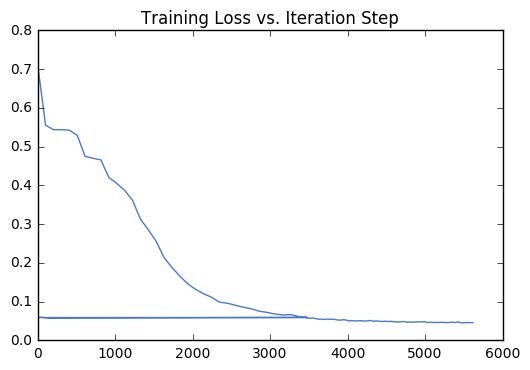

In [27]:
def test_model_output(filename):
    health_diagnostics,layer_diagnostics,good_ind,train_ind,validation_ind,test_ind = pickle.load( open( hyper_parameters['model_output_file_name'], "rb" ) )
    plt.plot(health_diagnostics['step'],health_diagnostics['trainLoss'])
    #plt.yscale('log')
    plt.title('Training Loss vs. Iteration Step')
    print("    Final Element Accuracy: %g"%health_diagnostics['trainElementAccuracy'][len(health_diagnostics['trainElementAccuracy'])-1])
    print("    Final Row Accuracy: %g"%health_diagnostics['trainRowAccuracy'][len(health_diagnostics['trainElementAccuracy'])-1])
    return health_diagnostics,layer_diagnostics


sess = tf.Session()
init = tf.global_variables_initializer()
saver = tf.train.Saver()
sess.run(init)
batch_size = hyper_parameters['batch_size']
layer_diagnostics = pd.DataFrame()
health_diagnostics = pd.DataFrame()

start = timeit.default_timer()
stop = start
output_step = 0
first_step = 0

#how often do we save the model in terms of output steps? it takes a while,
# esp. as we continue training, so don't do this for every output that happens
# roughly every hyper_parameters['step_update_in_seconds'] seconds (probably 30sec)
# setting to 5 means we save model checkpoint every 2.5 min
output_freq = 5 

if os.path.isfile(hyper_parameters['model_output_file_name']) and os.path.isfile(hyper_parameters['model_file_name']+'.index') :
    print("Model being restored from %s"%hyper_parameters['model_file_name'])
    
    health_diagnostics,layer_diagnostics = test_model_output(hyper_parameters['model_output_file_name'])
    
    saver.restore(sess, "./"+hyper_parameters['model_file_name'])
    
    output_step = int(max(health_diagnostics['outputStep'][health_diagnostics['modelSaved']==True]))
    first_step = int(max(health_diagnostics['step'][health_diagnostics['modelSaved']==True]))
    print(first_step)
    health_diagnostics.tail()
else:
    print("Model and Output File Not Found, Start Training from Scratch")
    

In [28]:
train_model = True
if train_model:
    start = timeit.default_timer()

    for i in range(first_step,int(hyper_parameters['num_train_steps_thresh'])+1):
        ind = next_batch(train_x.shape[0],batch_size)
        batch_x = train_x[ind]
        batch_y = train_y[ind]
        step_time = None
        if i > first_step: 
            if i<first_step+2: train_start = timeit.default_timer()
            sess.run(train_step, feed_dict={inputs:batch_x,true_y:batch_y, keep_prob1:0.5, keep_prob2:0.5, keep_prob3:0.5})
            if i<first_step+2: train_stop = timeit.default_timer()
            if i<first_step+2: 
                step_time = float((train_stop-train_start))
                print("Training time for 1000 steps: %g"%(1000*step_time))
                STEP_UPDATE = round(hyper_parameters['step_update_in_seconds']/step_time)
                print("Updating every %g seconds at %g steps"%(hyper_parameters['step_update_in_seconds'],STEP_UPDATE))

        if i <first_step+2 or ( i % STEP_UPDATE == 0 and i != first_step ) :

            fc1_weights_val, fc1_weights_grad_val,\
            fc1_biases_val, fc1_biases_grad_val,\
            fc2_weights_val, fc2_weights_grad_val,\
            fc2_biases_val, fc2_biases_grad_val,\
            fc3_weights_val, fc3_weights_grad_val,\
            fc3_biases_val, fc3_biases_grad_val,\
            fc4_weights_val, fc4_weights_grad_val,\
            fc4_biases_val, fc4_biases_grad_val,\
            fc5_weights_val, fc5_weights_grad_val,\
            fc5_biases_val, fc5_biases_grad_val,\
            out_y_val, out_y_grad_val,\
            trainAccuracy, trainAccuracy2, trainLoss =\
                sess.run([
                    fc1_weights, tf.gradients(loss,fc1_weights)[0],
                    fc1_biases, tf.gradients(loss,fc1_biases)[0],
                    fc2_weights, tf.gradients(loss,fc2_weights)[0],
                    fc2_biases, tf.gradients(loss,fc2_biases)[0],
                    fc3_weights, tf.gradients(loss,fc3_weights)[0],
                    fc3_biases, tf.gradients(loss,fc3_biases)[0],
                    fc4_weights, tf.gradients(loss,fc4_weights)[0],
                    fc4_biases, tf.gradients(loss,fc4_biases)[0],
                    fc5_weights, tf.gradients(loss,fc5_weights)[0],
                    fc5_biases, tf.gradients(loss,fc5_biases)[0],
                    out_y, tf.gradients(loss,out_y)[0],
                    accuracy, accuracy2, loss
                ],
                                    feed_dict={
                                        inputs:batch_x,
                                        true_y:batch_y,
                                        keep_prob1:1.0,
                                        keep_prob2:1.0,
                                        keep_prob3:1.0,
                                        keep_prob4:1.0})

            #validationAccuracy = sess.run(accuracy, 
            #                        feed_dict={
            #                            inputs:validation_x,
            #                            true_y:validation_y, 
            #                            keep_prob:1.0})

            fc1_norm = np.linalg.norm(fc1_weights_val)
            fc1_grad_norm = np.linalg.norm(fc1_weights_val)
            fc1_bias_norm = np.linalg.norm(fc1_biases_val)
            fc1_bias_grad_norm = np.linalg.norm(fc1_biases_val)
            fc2_norm = np.linalg.norm(fc2_weights_val)
            fc2_grad_norm = np.linalg.norm(fc2_weights_val)
            fc2_bias_norm = np.linalg.norm(fc2_biases_val)
            fc2_bias_grad_norm = np.linalg.norm(fc2_biases_val)
            fc3_norm = np.linalg.norm(fc3_weights_val)
            fc3_grad_norm = np.linalg.norm(fc3_weights_val)
            fc3_bias_norm = np.linalg.norm(fc3_biases_val)
            fc3_bias_grad_norm = np.linalg.norm(fc3_biases_val)
            fc4_norm = np.linalg.norm(fc4_weights_val)
            fc4_grad_norm = np.linalg.norm(fc4_weights_val)
            fc4_bias_norm = np.linalg.norm(fc4_biases_val)
            fc4_bias_grad_norm = np.linalg.norm(fc4_biases_val)
            fc5_norm = np.linalg.norm(fc5_weights_val)
            fc5_grad_norm = np.linalg.norm(fc5_weights_val)
            fc5_bias_norm = np.linalg.norm(fc5_biases_val)
            fc5_bias_grad_norm = np.linalg.norm(fc5_biases_val)
            out_y_norm = np.linalg.norm(out_y_val)
            out_y_grad_norm = np.linalg.norm(out_y_grad_val)


            layer_diagnostics = layer_diagnostics.append({
                    'step':i,
                    'layer':'fc1',
                    'weight_norm':fc1_norm,
                    'weight_grad_norm':fc1_grad_norm,
                    'bias_norm':fc1_bias_norm,
                    'bias_grad_norm':fc1_bias_grad_norm},ignore_index=True)
            layer_diagnostics = layer_diagnostics.append({
                    'step':i,
                    'layer':'fc2',
                    'weight_norm':fc2_norm,
                    'weight_grad_norm':fc2_grad_norm,
                    'bias_norm':fc2_bias_norm,
                    'bias_grad_norm':fc2_bias_grad_norm},ignore_index=True)
            layer_diagnostics = layer_diagnostics.append({
                    'step':i,
                    'layer':'fc3',
                    'weight_norm':fc3_norm,
                    'weight_grad_norm':fc3_grad_norm,
                    'bias_norm':fc3_bias_norm,
                    'bias_grad_norm':fc3_bias_grad_norm},ignore_index=True)
            layer_diagnostics = layer_diagnostics.append({
                    'step':i,
                    'layer':'fc4',
                    'weight_norm':fc4_norm,
                    'weight_grad_norm':fc4_grad_norm,
                    'bias_norm':fc4_bias_norm,
                    'bias_grad_norm':fc4_bias_grad_norm},ignore_index=True)
            layer_diagnostics = layer_diagnostics.append({
                    'step':i,
                    'layer':'fc5',
                    'weight_norm':fc5_norm,
                    'weight_grad_norm':fc5_grad_norm,
                    'bias_norm':fc5_bias_norm,
                    'bias_grad_norm':fc5_bias_grad_norm},ignore_index=True)
            layer_diagnostics = layer_diagnostics.append({
                    'step':i,
                    'layer':'out_y',
                    'weight_norm':out_y_norm,
                    'weight_grad_norm':out_y_grad_norm,
                    'bias_norm':0,
                    'bias_grad_norm':0},ignore_index=True)

            validationAccuracy, validationAccuracy2 = sess.run([accuracy, accuracy2], 
                                feed_dict={
                                    inputs:validation_x,
                                    true_y:validation_y,
                                        keep_prob1:1.0,
                                        keep_prob2:1.0,
                                        keep_prob3:1.0,
                                        keep_prob4:1.0})

            prev_stop = stop
            stop = timeit.default_timer()

            health_diagnostics_dict = {
                    'step':i,
                    'outputStep':output_step,
                    'hyperParameters':hyper_parameters,
                    'trainLoss':trainLoss,
                    'trainElementAccuracy':trainAccuracy,
                    'trainRowAccuracy':trainAccuracy2,
                    'validationElementAccuracy':validationAccuracy,
                    'validationRowAccuracy':validationAccuracy2,
                    'secondsSinceStart':(stop-start),
                    'trainStepTime':step_time,
                    'trainStartTime':start,
                    'currTrainAndOutputStepTime':(stop-prev_stop),
                    'modelSaved':False
                }


            if i==0: print('Initializing from scratch')
            elif first_step>0 and i==first_step: print('Initializing form prior save')
            else: print("Step %d:"%(i))
            print("    fc1 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
                  (fc1_norm, fc1_grad_norm, fc1_bias_norm, fc1_bias_grad_norm))
            print("    fc2 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
                  (fc2_norm, fc2_grad_norm, fc2_bias_norm, fc2_bias_grad_norm))
            print("    fc3 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
                  (fc3_norm, fc3_grad_norm, fc3_bias_norm, fc3_bias_grad_norm))
            print("    fc4 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
                  (fc4_norm, fc4_grad_norm, fc4_bias_norm, fc4_bias_grad_norm))
            print("    fc5 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
                  (fc5_norm, fc5_grad_norm, fc5_bias_norm, fc5_bias_grad_norm))
            print("    out_y_norm %g, grad norm %g"%(out_y_norm, out_y_grad_norm))
            print("    element-wise training accuracy %g, valid'n accuracy %g, loss %g"%(trainAccuracy, validationAccuracy,trainLoss))
            print("    row-wise     training accuracy %g, valid'n accuracy %g"%(trainAccuracy2, validationAccuracy2))
            #print("    percent training samples classified as not zero %g"%(100.0*float(np.sum((np.argmax(out_y_val,1))))/float(out_y_val.shape[0])))
            if i>first_step: 
                print("    seconds since start %g, since last update %g, ETA(s) %g"%((stop-start),(stop-prev_stop),(stop-start)*float(hyper_parameters['num_train_steps_thresh']-i)/float(i)))
                plt.plot(health_diagnostics['step'],health_diagnostics['trainLoss'])
                output_step += 1
                health_len = health_diagnostics.shape[0]
                prior_avg = health_diagnostics['trainLoss'].iloc[health_len-2]
                curr_avg = np.min(health_diagnostics['trainLoss'].iloc[(health_len-2):(health_len-1)])
                print("    incremental improvement since last update in percent: %g"%(100*(prior_avg-health_diagnostics['trainLoss'].iloc[(health_len-1)])/prior_avg))

            if i>(2000+first_step):
                health_len = health_diagnostics.shape[0]
                prior_avg = np.mean(health_diagnostics['trainLoss'].iloc[range(health_len-6,health_len-2)])
                curr_avg = health_diagnostics['trainLoss'].iloc[health_len-1]
                print("    moving-avg incremental improvement in percent: %g"%(100*(prior_avg-curr_avg)/prior_avg))
                if ((prior_avg-curr_avg)/float(prior_avg))<hyper_parameters['loss_diff_thresh']: 
                    print("Failing to meaningfully improve upon last five outputs")
                    break

            if trainAccuracy2>hyper_parameters['row_accuracy_thresh'] or trainAccuracy>hyper_parameters['element_accuracy_thresh']:
                print('Success! Shall stop training now although I could go further to improve loss function')
                break

            if output_step%output_freq==0:
                print("Saving model...")
                save_path = saver.save(sess, hyper_parameters['model_file_name'])
                print("Model saved in file: %s" % save_path)
                health_diagnostics_dict['modelSaved'] = True
            else:
                print("Skipped Saving Model")

            health_diagnostics = health_diagnostics.append(health_diagnostics_dict,ignore_index=True)
            pickle.dump((health_diagnostics,layer_diagnostics,good_ind,train_ind,validation_ind,test_ind),open(hyper_parameters['model_output_file_name'],'w'))
            print("Model Output saved to %s"%hyper_parameters['model_output_file_name'])

    #Finally when it exits on its own save the results!
    print("Self-Exit Detected: Saving Results")
    save_path = saver.save(sess, hyper_parameters['model_file_name'])
    print("Model saved in file: %s" % save_path)
    health_diagnostics_dict['modelSaved'] = True

    health_diagnostics = health_diagnostics.append(health_diagnostics_dict,ignore_index=True)
    pickle.dump((health_diagnostics,layer_diagnostics,good_ind,train_ind,validation_ind,test_ind),open(hyper_parameters['model_output_file_name'],'w'))
    print("Model Output saved to %s"%hyper_parameters['model_output_file_name'])
        

In [29]:
#ideas:
#add diminished and augmented triads, but just a few examples bc they're rare
#fully diminished seventh is its own thing right? how do I handle that because it has four-way ambiguity?
#can I create nonsense pitch classes that don't have an intinsic triad? that's the superset of
# diminished and augmented triads+extension.... 
#what is the story on ambiguity with seventh chords? there's really two overlapping triads
#what about a chord played by one instrument and the extension played by another instrument?

In [30]:
if train_model:
    #I want to get indices of train_x that are correctly, and incorrectly identified
    tmp1, tmp2 = sess.run([tf.nn.sigmoid(out_y), true_y], 
                                feed_dict={
                                    inputs:validation_x,
                                    true_y:validation_y, 
                                    keep_prob1:1.0,keep_prob2:1.0,keep_prob3:1.0,keep_prob4:1.0})

    #print("Correct Predictions:")
    #for i in np.where(np.sum(np.abs(np.round(tmp1)-tmp2),1)==0)[0]:
        #print('Guess vector: '+str(tmp1[i,:]))
        #print('Guess: '+str(np.where(np.round(tmp1[i,:])==1)))
        #tmp = np.power(validation_data['fft'].iloc[i],2.0)
        #tmp = librosa.istft(np.repeat(tmp.reshape([len(tmp),1]),10,axis=1))
        #IPython.display.display(IPython.display.Audio(data=tmp, rate=sr))
    #print("")    

    print("Incorrect Predictions:")
    for i in np.where(np.sum(np.abs(np.round(tmp1)-tmp2),1)!=0)[0]:
        print(i)
        print("Bank: %s"%ds_sub.iloc[validation_ind[i]]['bank'] + \
              "; Perc Multiplier: %g"%ds_sub.iloc[validation_ind[i]]['perc_multiplier'] + \
              "; Pitches per Pitch Class: %s"%str(ds_sub.iloc[validation_ind[i]]['pitches_per_pitch_class']) + \
              "; Pitch Shift: %g"%ds_sub.iloc[validation_ind[i]]['pitch_shift']+ \
              "; Inter-Note Pitch Shift Range: %s"%str(ds_sub.iloc[validation_ind[i]]['inter_note_pitch_shift_range']))
        #print('Guess vector: '+str(tmp1[i,:]))
        print('Guess: '+str(np.where(np.round(tmp1[i,:])==1))+'; Reality: '+str(np.where(tmp2[i,:]==1)))
        #tmp = np.power(validation_data['fft'].iloc[i],2.0)
        #tmp = librosa.istft(np.repeat(tmp.reshape([len(tmp),1]),10,axis=1))
        #IPython.display.display(IPython.display.Audio(data=tmp, rate=sr))
    print("")    

NameError: name 'validation_x' is not defined

# Test on New Datasets

In [31]:
def get_fft(sample):
    try:
        if np.sum(np.abs(sample))<1.0: return []
        S_sample = np.abs((librosa.stft(sample)))**0.5
        tmp = np.abs(S_sample[:,S_sample.shape[1]/2])
        return tmp/np.sum(tmp)
    except:
        return []
    

#audio_path = librosa.util.example_audio_file()

emaj, sr = librosa.load('emaj.aiff')
amaj, sr = librosa.load('amaj.aiff')

emaj_fft = get_fft(emaj)
qmaj_fft = get_fft(librosa.effects.pitch_shift(emaj,sr,n_steps=1))
amaj_fft = get_fft(amaj)
emaj_fft = emaj_fft/np.sum(emaj_fft)
qmaj_fft = qmaj_fft/np.sum(qmaj_fft)
amaj_fft = amaj_fft/np.sum(amaj_fft)

rwds = pd.DataFrame() #real-world dataset

#http://www.electronics.dit.ie/staff/tscarff/Music_technology/midi/midi_note_numbers_for_octaves.htm
emaj_dict = {'root':4,'majmin3':'maj','majmin7':'none','pitch_class':[4, 8, 11]}
#emaj_dict.update({'target':label_to_chord.index(emaj_dict)})
emaj_dict.update({'fft':emaj_fft})
qmaj_dict = {'root':5,'majmin3':'maj','majmin7':'none','pitch_class':[0, 5, 9]}
#qmaj_dict.update({'target':label_to_chord.index(qmaj_dict)})
qmaj_dict.update({'fft':qmaj_fft})
amaj_dict = {'root':9,'majmin3':'maj','majmin7':'none','pitch_class':[1, 4, 9]}
#amaj_dict.update({'target':label_to_chord.index(amaj_dict)})
amaj_dict.update({'fft':amaj_fft})



rwds = rwds.append(emaj_dict,ignore_index=True)
rwds = rwds.append(qmaj_dict,ignore_index=True)
rwds = rwds.append(amaj_dict,ignore_index=True)

#rwds["one_hot_encoding"] = [to1hot(x,len(label_to_chord)) for x in rwds['target']]
rwds["multi_hot_encoding"] = [toMultiHot(x,12) for x in rwds['pitch_class']]



realworld_x = np.vstack(rwds['fft']).reshape(rwds.shape[0],rwds['fft'].iloc[0].shape[0],1,1).astype(np.float32)
#realworld_y = np.vstack(rwds["one_hot_encoding"])
realworld_y = np.vstack(rwds["multi_hot_encoding"])


tmp1, tmp2 = sess.run([tf.nn.sigmoid(out_y), true_y], 
                            feed_dict={
                                inputs:realworld_x,
                                true_y:realworld_y, 
                                keep_prob1:1.0, keep_prob2:1.0, keep_prob3:1.0,keep_prob4:1.0})

for i in range(tmp1.shape[0]):
    #print('Guess vector: '+str(tmp1[i,:]))
    print('Guess: '+str(np.where(np.round(tmp1[i,:])==1))+' Reality: '+str(np.where(tmp2[i,:]==1)))

Guess: (array([0, 5, 9]),) Reality: (array([ 4,  8, 11]),)
Guess: (array([ 1,  6, 10]),) Reality: (array([0, 5, 9]),)
Guess: (array([ 2,  5, 10]),) Reality: (array([1, 4, 9]),)


In [32]:
def extract_fft(sample):
    try:
        S_sample = np.abs((librosa.stft(sample)))**0.5
        return S_sample[:,range(0,S_sample.shape[1],9)]
    except:
        return []

song_file_name = 'Something.aiff'
print("Loading "+song_file_name)

something, something_sr = librosa.load(song_file_name)

    
tmp = extract_fft(something)
print("Analysis on "+song_file_name)
print('Samples per sec: %g'%(876/3.03/60))


something_harmonic, something_percussive = librosa.effects.hpss(something)
print('Finished getting harmonic signal with SR: '+str(something_sr))

something_x = extract_fft(something_harmonic).transpose()
something_x = something_x.reshape([something_x.shape[0], something_x.shape[1], 1, 1])
something_x.shape


Loading Something.aiff
Analysis on Something.aiff
Samples per sec: 4.81848
Finished getting harmonic signal with SR: 22050


(876, 1025, 1, 1)

In [33]:

#I want to get indices of train_x that are correctly, and incorrectly identified
tmp1 = sess.run(tf.round(tf.nn.sigmoid(out_y)), 
                            feed_dict={
                                inputs:something_x,
                                #true_y:validation_y, 
                                keep_prob1:1.0,keep_prob2:1.0,keep_prob3:1.0})


print("Predictions:")
for i in range(tmp1.shape[0]):
    print(np.where(tmp1[i,:]==1)[0])

Predictions:
[ 2  6 10 11]
[ 2  6 11]
[ 2  7 10]
[6]
[ 4  8 11]
[0 9]
[ 2  6 11]
[ 3  6 10]
[ 3  6 10]
[ 2  6 11]
[3 6]
[ 1  6 10]
[ 3  6 11]
[1 8]
[1 6]
[ 3  6 11]
[ 3  6 11]
[ 3  6 11]
[1 4 9]
[ 4  8 11]
[1 4 8]
[4 8]
[ 4  8 11]
[0 3 8]
[1 8]
[1 8]
[ 2  6 11]
[1 5]
[1 8]
[1 4 8]
[0 3 6]
[1 4 8]
[1 6]
[1 4 8]
[1 4 8]
[1 4 8]
[1 4 8]
[1 5 8]
[1 4 8]
[1 4 8]
[4 7]
[ 8 11]
[1 4 8]
[ 2  7 11]
[ 2  7 10]
[2 7]
[1]
[ 1 10]
[1]
[ 1 10]
[ 1 10]
[1 4 8]
[1 8]
[ 1 10]
[1 6]
[1]
[1]
[1]
[1 4 8]
[1 4 8]
[1 4 8]
[ 1 10]
[1 4 8]
[1 4 8]
[1 4 8]
[ 4  8 11]
[ 4  8 11]
[ 4  8 11]
[ 2  7 11]
[ 2  7 11]
[ 2  7 11]
[ 2  7 10]
[1 4 8]
[ 4  8 11]
[0 4 7]
[0 4 7]
[1 4 8]
[ 4  7 11]
[1 4 8]
[1 4 8]
[ 1  8 10]
[ 1  6 10]
[ 1  6 10]
[1 6]
[1 6]
[ 3  6 11]
[ 6 11]
[ 6 11]
[ 1  6 10]
[ 6 10]
[1 6]
[10]
[ 3  6 10]
[ 6 10]
[1 6]
[1 6]
[ 3  6 11]
[ 3  6 11]
[ 3  7 10]
[ 3 10]
[2 6 9]
[0 9]
[4 9]
[3 6]
[0 4 9]
[ 3  7 10]
[ 3  4 11]
[0 3 4 7]
[0 3 7]
[3 6]
[0 3]
[3 6]
[ 3  6 10]
[ 3  6 11]
[ 3  8 11]
[1 4 8]
[ 4  8 1

In [34]:
#import sounddevice as sd
import music21 as m21
%load_ext music21.ipython21

In [35]:
s = m21.stream.Stream()
print("Predictions:")
for i in range(tmp1.shape[0]):
    pitch_class = [(x-1)%12 for x in np.where(tmp1[i,:]==1)[0]]
    c = m21.chord.Chord(pitch_class)
    print(c.pitchedCommonName)
    c.duration.type = 'eighth'
    s.append(copy.copy(c))


Predictions:
A-minor-augmented tetrachord
A#-minor triad
F#-minor triad
F-unison
E--major triad
G#-interval class 3
A#-minor triad
D-minor triad
D-minor triad
A#-minor triad
D-interval class 3
F-major triad
B--major triad
C-interval class 5
F-interval class 5
B--major triad
B--major triad
B--major triad
A--major triad
E--major triad
C-minor triad
E--interval class 4
E--major triad
G-major triad
C-interval class 5
C-interval class 5
A#-minor triad
C-interval class 4
C-interval class 5
C-minor triad
B-diminished triad
C-minor triad
F-interval class 5
C-minor triad
C-minor triad
C-minor triad
C-minor triad
C-major triad
C-minor triad
C-minor triad
E--interval class 3
G-interval class 3
C-minor triad
F#-major triad
F#-minor triad
F#-interval class 5
C-unison
A-interval class 3
C-unison
A-interval class 3
A-interval class 3
C-minor triad
C-interval class 5
A-interval class 3
F-interval class 5
C-unison
C-unison
C-unison
C-minor triad
C-minor triad
C-minor triad
A-interval class 3
C-minor tr

In [36]:
s.show('midi')

In [ ]:
#I would say that the "Something" example shows we need more diverse training data to start getting complex
# produced popular music to classify meaningfully, or for its MIDI-rendered interpretation to sound
# anything even like actual music....
# But let's check out how it works on my guitarlele below

# Real-Time Microphone Testing: Play Your Instrument!

In [49]:
import sounddevice as sd
import librosa

def get_fft(sample):
    try:
        if np.sum(np.abs(sample))<1.0: return []
        S_sample = np.abs((librosa.stft(sample)))**0.5
        tmp = np.abs(S_sample[:,S_sample.shape[1]/2])
        #Fix this so that it only returns if the FFT at the middle point crosses a threshold
        return tmp/np.sum(tmp)
    except:
        return []

G-minor triad
B-major triad
E--major triad
A-major triad
A-major triad
A-major triad
D-interval class 5
D-interval class 5
D-minor triad
D-major triad
D-major triad
D-major triad
A-interval class 5
A-major triad
A-major triad
B-minor triad
D-major triad
E-interval class 5
E-interval class 5
E-major triad
A--major seventh chord
G-incomplete major-seventh chord
D-major triad
E-major triad
E-interval class 5
E-unison
E-interval class 4
E-interval class 5
C#-minor triad
E-major triad
E-interval class 4
G-minor triad
D-major triad
D-major triad
D-major triad
C-major triad
C-major triad
C-interval class 5
B--interval class 5
A-major triad
D-minor triad
C-interval class 5
G#-minor triad
G-interval class 5


KeyboardInterrupt: 

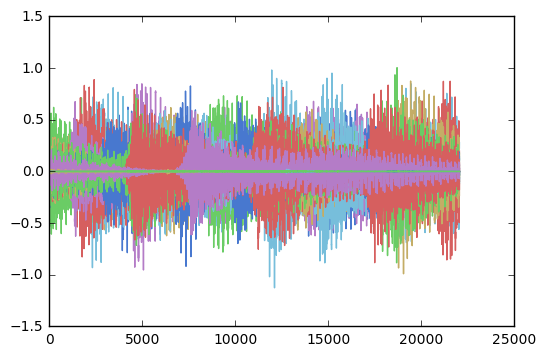

In [66]:
#HERE WRITE A LOOP THAT LISTENS IN AND TELLS YOU THE MOST-RECENTLY PLAYED CHORD
duration = 1  # seconds
sr = 22050
s = m21.stream.Stream()


while True:
    sample = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait()
    sample = np.reshape(sample,sample.shape[0])
    plt.plot(sample)
    fft = get_fft(sample)
    if len(fft)==0:
        print('invalid sample')
        continue
    
    tmp1 = sess.run([tf.nn.sigmoid(out_y)], 
                            feed_dict={
                                inputs:np.reshape(fft,[1,len(fft),1,1]),
                                true_y:np.reshape(np.zeros(NUM_LABELS),[1,NUM_LABELS]), 
                                keep_prob1:1.0, keep_prob2:1.0, keep_prob3:1.0,keep_prob4:1.0})

    pitch_class = [(x-1)%12 for x in np.where(np.round(tmp1[0])[0]==1)[0]]
    if len(pitch_class)==0:
        print('No identified pitch classes')
        continue
    c = m21.chord.Chord(pitch_class)
    print(c.pitchedCommonName)
    c.duration.type = 'quarter'
    s.append(copy.copy(c))
    

In [ ]:
#Wow, it works! While not every chord it identifies is correct,
# when it got the major triads in a sequence those were indeed the major triads I was playing